In [1]:
# Replace part of the OUTPUT_PATH to create a new folder 
# for the detection results
EXPERIMENT_NAME= "Temp3"
OUTPUT_PATH = EXPERIMENT_NAME + "/LoanApplications_Offline/"
NEW_OUTPUT_PATH = EXPERIMENT_NAME + "/LoanApplications_Offline__DETECTION/"
OUTPUT_RESULTS = EXPERIMENT_NAME + "/Results/"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from tqdm.notebook import tqdm_notebook

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# My packages
from source import parse_mxml as pm
from source import log_representation as lr
from source import plots as plts
from source import drift_detection as dd
from source import drift_localization as dl
from source import offline_streaming_clustering as off_sc

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed, parallel_backend

import random
random.seed(42)

import os
import glob

import gc
gc.enable()

from scipy.spatial import distance
from sklearn.base import clone as sk_clone 

from copy import deepcopy

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', 100)

In [3]:
def insensitive_glob(pattern):
    def either(c):
        return '[%s%s]' % (c.lower(), c.upper()) if c.isalpha() else c
    return glob.glob(''.join(map(either, pattern)))

def if_any(string, lista):
    # If the string contains any of the values
    # from the list 'lista'
    for l in lista:
        if l in string:
            return True
    return False

In [4]:
# List log files
logs = insensitive_glob(r"../../../../../../../Datasets/Business_Process_Drift_Logs/Logs/*/*k.MXML")
logs = [x.replace('\\', '/') for x in logs if "2.5" not in x]
# logs = [x for x in logs if "2.5" not in x]

In [5]:
# reference objects and map them to strings in dict 
# used in further methods
objects = {
    "model": {
#         "kmeans__k1": KMeans(n_clusters=1, random_state=42)
        "kmeans__k2": KMeans(n_clusters=2, random_state=42)
        
        ,"DBSCAN__eps5ms3met=man": DBSCAN(eps=5, min_samples=3, metric='manhattan')
        ,"DBSCAN__eps6ms3met=man": DBSCAN(eps=6, min_samples=3, metric='manhattan')
        ,"DBSCAN__eps4ms3met=man": DBSCAN(eps=4, min_samples=3, metric='manhattan')
        ,"DBSCAN__eps5ms2met=man": DBSCAN(eps=5, min_samples=2, metric='manhattan')
        ,"DBSCAN__eps5ms4met=man": DBSCAN(eps=5, min_samples=4, metric='manhattan')
        

    },
    
    "representation": {
        "activity_binary": lr.get_binary_representation,
        "activity_frequency": lr.get_frequency_representation,
        
        "transitions_binary": lr.get_binary_transitions_representation,
        "transitions_frequency": lr.get_frequency_transitions_representation,
        
        "activity_tfidf": lr.get_tfidf_representation,
        "transitions_tfidf": lr.get_tfidf_transitions_representation,
        
        "act_trans_frequency": lr.get_activity_transitions_frequency_representation,
        "act_trans_binary": lr.get_activity_transitions_binary_representation
    }
#     "representation": {
#         "activity_binary": lambda x: lr.get_binary_representation(lr.get_traces_as_tokens(x)),
#         "activity_frequency": lambda x: lr.get_frequency_representation(lr.get_traces_as_tokens(x)),
#         "transitions_binary": lambda x: lr.get_binary_transitions_representation(lr.get_traces_as_tokens(x)),
#         "transitions_frequency": lambda x: lr.get_frequency_transitions_representation(lr.get_traces_as_tokens(x)),
#         "activity_transitions_frequency": lambda x: pd.concat([lr.get_frequency_transitions_representation(lr.get_traces_as_tokens(x)), lr.get_frequency_representation(lr.get_traces_as_tokens(x))],axis=1),
#         "activity_transitions_binary": lambda x: pd.concat([lr.get_binary_transitions_representation(lr.get_traces_as_tokens(x)), lr.get_binary_representation(lr.get_traces_as_tokens(x))],axis=1)
#     }
}

In [6]:
distance_list=['euclidean', 'hamming','cityblock', 'jaccard', 'cosine']

In [7]:
# change patterns and they supported representations
activity_binary_drifts = ["cb", "cf", "cm", "fr", "pm", "re", "rp"]
activity_frequency_drifts = activity_binary_drifts + ["cp", "lp"]

transitions_binary_drifts = activity_frequency_drifts + ["cd", "pl", "sw"] #+ ["IOR", "IRO", "OIR", "ORI", "RIO", "ROI"]
transitions_frequency_drifts = transitions_binary_drifts

activity_tfidf_drifts = transitions_binary_drifts
transitions_tfidf_drifts = transitions_binary_drifts

activity_transitions_frequency_drifts = transitions_binary_drifts
activity_transitions_binary_drifts = transitions_binary_drifts

### Pipeline Offline Clustering

In [8]:
def read_file_and_run_clustering_pipeline(args, return_result=False):
    """
    Read an event log file, represent it into a feature vector space and
    run the trace clustering method over windows. This method outputs results
    as gzip csv files into the "OUTPUT_PATH" folder, or return the result 
    as DataFrame when return_result = True.
    
    Parameters:
    -----------
        args (dict): Dictionary with the parameters and the log_file path
            requiring the following keys:
                example = {
                    'log': <PATH TO LOG_FILE>,
                    'representation': <KEY TO REPRESENTATIONS IN 'objects'>,
                    'parameters': [{
                        'model': <KEY TO MODEL IN 'objects'>, 
                        'sliding_window': <WHETHER TO USE SLIDING WINDOW>,
                        'window_size': <SIZE OF TRACE WINDOW TO USE>,
                        'sliding_step': <STEP OF SLIDING WINDOW>
                    }
        return_result (bool): Whether to return the result as DataFrame
            
    """
    
    # Treat file name to structure size and log type
    split = args["log"].split("/")
    
    # Parse change pattern name
    cd_name = split[-2]
    log_name = split[-1][:-5]
    
    # Set up true drifts indexes
#     y_true = [x for x in range(int(log_size/10), log_size, int(log_size/10))]
    
    try:
        # Read log and apply trace representation technique
        log_read = pm.all_prep(open(args["log"]))
        tokens = lr.get_traces_as_tokens(log_read)
#         df = objects["representation"][args["representation"]](log_read)

        # Parse size of the event_log
#         log_size = log_name.replace(cd_name, "").replace("new_", "")
#         log_size = int(float(log_size.replace("k", "")) * 1000)
        log_size = len(tokens)
        
        for p in args["parameters"]:
            # String to identify results when exporting files
            tipo_mudanca = cd_name.replace("new_", "")
            
            cached_info = "_".join([
                tipo_mudanca,
                str(log_size),
                p["model"],
                args["representation"],
                str(p["window_size"]),
                str(p["sliding_window"])
            ])
            
            print(cached_info)
            
            # If already exists, return if needed
            file_to_export = OUTPUT_PATH + tipo_mudanca + '/' + cached_info + '.pickle.gzip'
            if os.path.exists(file_to_export):
                if return_result:
                    r_ = pd.read_pickle(
                        file_to_export,
                        compression='gzip'
                    )
                    return r_
                else:
                    continue
            
            # If file does not exists, run trace clustering step and export file
            all_metrics, X = off_sc.run_offline_clustering_window(
                tokens,
                objects["representation"][args["representation"]],
                sk_clone(objects["model"][p["model"]]),
                distance_list,
                p["window_size"],
#                 df,
                p["sliding_window"],
                sliding_step=p['sliding_step']
            )
            
            # Set up true drifts indexes and append
#             y_true = list(range(int(len(tokens)/10), len(tokens), int(len(tokens)/10)))
#             all_metrics["y_true"] = all_metrics.apply(lambda x: y_true, axis = 1)
            
            if return_result:
                return all_metrics
            else:
                try:
                    os.makedirs(OUTPUT_PATH + tipo_mudanca + '/')
                except:
                    pass
                all_metrics.to_pickle(file_to_export, compression="gzip")

            gc.collect()
    except Exception as e:
        raise e
#     print("###################################################################")

#### Run pipeline for specific case(s)

In [9]:
# read_file_and_run_clustering_pipeline({
#     'log': logs[0],
#     'representation': 'activity_binary',
#     'parameters': [{
#         'model': 'HDBSCAN__noparams', 
#         'sliding_window': False,
#         'window_size': 75,
#         'sliding_step': 1
#     }]
# }, return_result=True)

### Run Experiments with several parameters combinations

In [10]:
# Trace clustering parameters
grid_parameters = list(ParameterGrid({
    "sliding_window": [False]    
    ,"window_size": [100, 125, 150]
    ,'sliding_step': [1]
    ,"model": [
#         "kmeans__k1"
        "kmeans__k2"
        
        ,"DBSCAN__eps5ms3met=man"
        ,"DBSCAN__eps6ms3met=man"
        ,"DBSCAN__eps4ms3met=man"
        ,"DBSCAN__eps5ms2met=man"
        ,"DBSCAN__eps5ms4met=man"
    ] 
}))

# Trace vector representations
grid_logs = list(ParameterGrid([
    { "log": [x for x in logs if if_any(x, activity_binary_drifts)],
        "representation": ["activity_binary"]}
    ,{"log": [x for x in logs if if_any(x, activity_frequency_drifts)],
        "representation": ["activity_frequency"]}
    
    ,{ "log": [x for x in logs if if_any(x, transitions_binary_drifts)],
        "representation": ["transitions_binary"]}
    ,{ "log": [x for x in logs if if_any(x, transitions_frequency_drifts)],
        "representation": ["transitions_frequency"]}
    
    ,{ "log": [x for x in logs if if_any(x, activity_tfidf_drifts)],
        "representation": ["activity_tfidf"]}
    ,{"log": [x for x in logs if if_any(x, transitions_tfidf_drifts)],
        "representation": ["transitions_tfidf"]}
    
    ,{"log": [x for x in logs if if_any(x, activity_transitions_frequency_drifts)],
        "representation": ["act_trans_frequency"]}
    ,{"log": [x for x in logs if if_any(x, activity_transitions_binary_drifts)],
        "representation": ["act_trans_binary"]}
]))

# Combining all parameters
combs = []
for x in grid_logs:
    dic = x.copy()
    dic['parameters'] = grid_parameters
    
    combs.append(dic)

len(combs), len(grid_parameters), len(combs) * len(grid_parameters) 

(264, 18, 4752)

#### Run parallely

In [11]:
final_resp = Parallel(n_jobs=-1)(
    delayed(read_file_and_run_clustering_pipeline)(comb) for comb in tqdm_notebook(combs)
)
gc.collect()

1152

### Detection Pipeline

In [12]:
# Drift detection parameters
drift_config = list(ParameterGrid([
    {
        "rolling_window": [3, 4]
        ,"std_tolerance": [1, 2, 3]#[1, 1.5, 2, 2.5, 3]
        ,'min_tol': [0.003, 0.010, 0.025, 0.1]#[0.0025, 0.025, 0.25] #[0.01, 0.007, 0.005, 0.003] 
    }
]))
print(len(drift_config))

24


In [13]:
# List all files obtained after the trace clustering pipeline

clusterizacoes = glob.glob(OUTPUT_PATH + "*/*.pickle.gzip")
print(len(clusterizacoes))

4752


In [14]:
# Combinations to run

combs_deteccao = []
for log in clusterizacoes:
    combs_deteccao.append({
        'input': log,
        'combinations': drift_config
    })
print(len(clusterizacoes)*len(drift_config))

114048


In [15]:
def drift_detect_pipeline(args, return_results=False):
    """
        Runs the drift detection method based on the output from the trace
        clustering pipeline for different combination of parameters and every
        feature from tracking the trace clustering evolution. The
        outputs are into a new folder named by the NEW_OUTPUT_PATH variable in 
        gzip csv files.
        
        Parameters:
        -----------
            args (dict): Dictionary with the parameters and the log_file path
                requiring the following keys:
                    example = {
                    }
    """
    # Read file
    all_metrics = pd.read_pickle(args["input"], compression='gzip')
    
    # Parse information from file name
    path_file = args["input"].replace(".pickle.gzip", "").split('\\')
    args.update({
        "tipo_mudanca": path_file[-1].split('_')[0],
        "log_size": int(path_file[-1].split('_')[1]),
        "model": "_".join(path_file[-1].split('_')[2:5]),
        "representation": "_".join(path_file[-1].split('_')[5:-2]),
        "window_size": path_file[-1].split('_')[-2],
        "sliding_window": path_file[-1].split('_')[-1]
    })
    
    # Run detection for every combination of parameter    
    for combination in args['combinations']:
        c = deepcopy(combination)
        c.update({
            'input': args['input'],
            'tipo_mudanca': args['tipo_mudanca'],
            'log_size': args['log_size'],
            'model': args['model'],
            'representation': args['representation'],
            'window_size': args['window_size'],
            'sliding_window': args['sliding_window']
        })
        
        if return_results:
            return __drift_detect_pipeline(
                all_metrics, c, return_results
            )
        else:
            __drift_detect_pipeline(
                all_metrics, c, return_results
            )
    

def __drift_detect_pipeline(all_metrics, args, return_results=False):     
    base_name = args["input"].replace(".pickle.gzip", "").replace("\\", "/")
    base_name = base_name.replace(OUTPUT_PATH, NEW_OUTPUT_PATH)
    
    # Create string with parameters to identify file
    to_string = [
        str(args["rolling_window"]),
        str(args["std_tolerance"]).replace(".", "-"), 
        str(args["min_tol"]).replace(".", "-")
    ]
    
    try:
        os.makedirs(base_name)
    except:
        pass
    
    final_name = base_name + "/" + "_".join(to_string) + ".pickle.gzip"
#     final_name = base_name.replace("\\", "/") + "_".join(to_string) + ".pickle.gzip"
    
    if os.path.isfile(final_name):
        if return_results:
            return pd.read_pickle(final_name, compression='gzip')
        else:
            print("Already exists")
            return
    
    # Set up true drifts indexes
    y_true = [x for x in range(int(args['log_size']/10), args['log_size'], int(args['log_size']/10))]
#     y_true = list(range(int(len(tokens)/10), len(tokens), int(len(tokens)/10)))
#     all_metrics["y_true"] = all_metrics.apply(lambda x: y_true, axis = 1)

    # Set up acceptable error - how many iterations from ground truth
    margin_error = 2

    # Runs the drift detection for every feature
    results = []
    for col in all_metrics.select_dtypes(include=np.number).columns:
        if (col not in ["i","test_id"]):
#         if (col not in ["k"] and not col.startswith("diff") ) or col in ["diff_centroids"]:
            r = deepcopy(args)
            r["measure"] = col

            detected_drifts, not_drifts, info = dd.detect_concept_drift(
                all_metrics, 
                col,
                args["rolling_window"],
                args["std_tolerance"],
                args["min_tol"]
            )    
    
            # Calculate classification metrics
            
            metrics_results = dd.get_metrics(
                detected_drifts
                ,not_drifts
#                 ,all_metrics["y_true"].iloc[0] 
                , y_true
                ,int(args["window_size"])
                , int(args['log_size'])
                , margin_error
            )

            r.update(args)
            r.update(metrics_results)

            results.append(r)

            gc.collect()

    # Export as file
    pd.DataFrame(results).to_pickle(
        final_name,
        compression="gzip"
    )

    if return_results:
        return pd.DataFrame(results)
    
    # print(col, len(results))

In [16]:
# detection_results = drift_detect_pipeline({
#     'input': '../LoanApplications_Offline\\cb\\cb_10000_kmeans__k=2_binary_100_False.pickle.gzip',
#     'combinations': [{
#        'min_tol': 0.01,
#        'rolling_window': 3,
#        'std_tolerance': 1.25
#     }, {
#        'min_tol': 0.02,
#        'rolling_window': 3,
#        'std_tolerance': 1.25
#     }]
# }, return_results=True)

#### Run parallely

In [17]:
final_resp = Parallel(n_jobs=-1)(
    delayed(drift_detect_pipeline)(comb_d) for comb_d in tqdm_notebook(combs_deteccao)
)

## Consolidate Results

In [28]:
models = [
#         "kmeans__k1"
        "kmeans__k2"
        
        ,"DBSCAN__eps5ms3met=man"
        ,"DBSCAN__eps6ms3met=man"
        ,"DBSCAN__eps4ms3met=man"
        ,"DBSCAN__eps5ms2met=man"
        ,"DBSCAN__eps5ms4met=man"
]

# Function to Read results
def consolidate_results(log):
    return pd.read_pickle(log, compression='gzip')

In [29]:
for model in models:
    # List all files obtained after the trace clustering pipeline
    deteccoes = glob.glob(NEW_OUTPUT_PATH + "/*/*"+model+"*/*.pickle.gzip")

    # Call function to read results and then consolidate
    all_results = pd.DataFrame()
    all_results = all_results.append(Parallel(n_jobs=-1)(
        delayed(consolidate_results)(log) for log in tqdm_notebook(deteccoes)
    ))
    
    # Export as file
    all_results.to_pickle(
        EXPERIMENT_NAME + '/all_results_' + model,
        compression="gzip"
    )

## See Results

In [66]:
model=models[6]
model

IndexError: list index out of range

In [ ]:
# Import as file
all_results = pd.read_pickle(EXPERIMENT_NAME + '/all_results_' + model, compression='gzip')
print(all_results.shape)

# Create export 
try:
    os.makedirs(OUTPUT_RESULTS)
except:
    pass


# Group results by all params and get the mean F1 and Delay among all scenarios
# In other words, what combination of params got the best results in all scenarios

params = ["min_tol", "rolling_window", "std_tolerance", "window_size", "measure", "representation"]
scenarios = ["tipo_mudanca", "log_size"]
validation_metrics = ["F1","Delay","Mean_test_per_drift"]#,"Support","Precision","Recall"]

all_results_grouped = all_results.groupby(params)[validation_metrics].agg(['mean','std'])
all_results_grouped.columns = all_results_grouped.columns.map('_'.join)
all_results_grouped.sort_values(["F1_mean","Delay_mean"], ascending=[False,True], inplace=True)
# all_results_grouped.to_excel(OUTPUT_RESULTS + 'all_results_grouped_'+model+'.xlsx', sheet_name=model)
all_results_grouped.head(50)

In [67]:
best_results_by_representation = all_results_grouped.reset_index().groupby("representation").first().reset_index().sort_values(["F1_mean","Delay_mean"], ascending=[False,True])
best_results_by_representation

,representation,min_tol,rolling_window,std_tolerance,window_size,measure,F1_mean,F1_std,Delay_mean,Delay_std,Mean_test_per_drift_mean,Mean_test_per_drift_std
5,transitions_binary,0.100,3,1,125,count_non_zero_MSE,0.865036,0.290152,1.063657,0.439962,3.416667,1.926768
6,transitions_frequency,0.003,3,3,125,count_non_zero_MSE,0.862343,0.287123,0.967989,0.354553,3.537037,1.913380
3,activity_frequency,0.003,3,1,125,count_non_zero_MSE,0.861858,0.296135,1.306070,0.523664,3.423868,1.863081
2,activity_binary,0.003,3,1,125,count_non_zero_MSE,0.826622,0.328718,1.322751,0.562078,3.507937,1.908904
7,transitions_tfidf,0.003,3,3,125,mean_diff_centroids,0.793642,0.185833,1.000022,0.263646,3.469136,1.628908
0,act_trans_binary,0.003,3,3,125,mean_diff_centroids,0.791173,0.176063,0.909799,0.277266,3.237654,1.412255
1,act_trans_frequency,0.003,3,3,125,mean_diff_centroids,0.779538,0.165045,0.981911,0.220230,3.339506,1.505767
4,activity_tfidf,0.003,3,2,125,n_variants,0.695056,0.162375,0.842725,0.373556,3.037037,1.132804


In [63]:
best_result = pd.merge(left=all_results
            , right=best_results_by_representation
            , how='inner', on=params)
results_table = best_result.pivot_table(values=["F1"]#,"Delay"]
                                        , index=["tipo_mudanca"]
                                        , columns=["representation"]
                                        , aggfunc='mean')\
                                    .sort_index(axis='columns',level=[1,0], ascending=[True,False])

results_table.to_excel(OUTPUT_RESULTS + 'results_table_'+model+'.xlsx', sheet_name=model)
results_table

F1                                      \
representation act_trans_binary act_trans_frequency activity_binary   
tipo_mudanca                                                          
cb                     0.726190            0.701852        0.982456   
cd                     0.781955            0.740741             NaN   
cf                     0.920635            0.795207        0.982456   
cm                     0.839651            0.799510        0.949123   
cp                     0.814035            0.789474             NaN   
fr                     0.583333            0.546032        0.055556   
lp                     0.643573            0.659148             NaN   
pl                     0.710001            0.814815             NaN   
pm                     0.920635            0.892673        0.982456   
re                     0.814035            0.836257        0.888889   
rp                     0.909091            0.896296        0.945419   
sw                     0.830941            0.882456             NaN   

                                                                     \
representation activity_frequency activity_tfidf transitions_binary   
tipo_mudanca                                                          
cb                       0.982456       0.759180           1.000000   
cd                            NaN       0.715823           1.000000   
cf                       0.982456       0.832244           0.904762   
cm                       0.949123       0.732245           1.000000   
cp                       0.962963       0.613072           1.000000   
fr                       0.055556       0.577285           0.000000   
lp                       0.933333       0.787948           0.746032   
pl                            NaN       0.787037           0.962963   
pm                       0.982456       0.689327           1.000000   
re                       0.962963       0.640212           0.766676   
rp                       0.945419       0.638095           1.000000   
sw                            NaN       0.568208           1.000000   

                                                        
representation transitions_frequency transitions_tfidf  
tipo_mudanca                                            
cb                          0.904762          0.762281  
cd                          0.962963          0.603947  
cf                          1.000000          0.826006  
cm                          1.000000          0.855392  
cp                          1.000000          0.801170  
fr                          0.000000          0.677399  
lp                          0.700758          0.601995  
pl                          0.962963          0.803535  
pm                          1.000000          0.853968  
re                          0.816667          0.829630  
rp                          1.000000          0.982456  
sw                          1.000000          0.925926

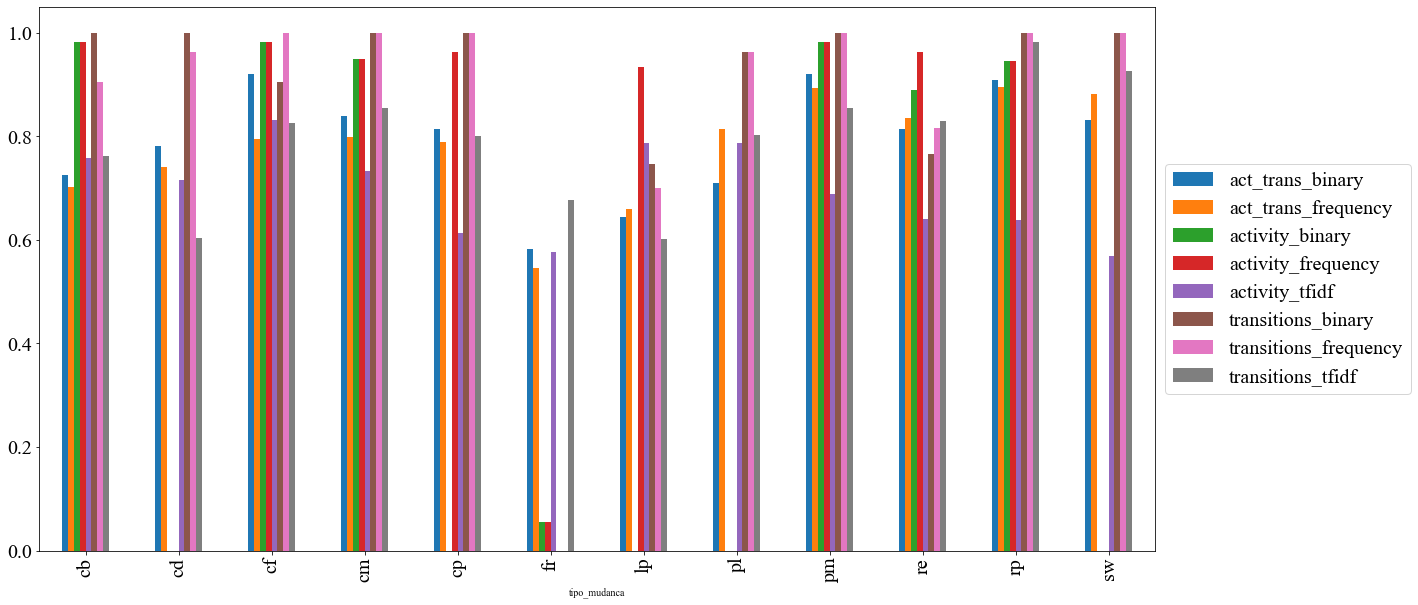

In [64]:
results_table['F1'].plot(kind='bar', figsize=(20,10), fontsize=20)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=20)
plt.show()

In [65]:
results_table_logsize = best_result.pivot_table(values=["F1"]#,"Delay"]
                                                , index=["tipo_mudanca"]
                                                , columns=["representation"
                                                , "log_size"]
                                                , aggfunc='mean')\
                                    .sort_index(axis='columns',level=[1,0], ascending=[True,False])

results_table_logsize.to_excel(OUTPUT_RESULTS + 'results_table_logsize_'+model+'.xlsx', sheet_name=model)
results_table_logsize

F1                                          \
representation act_trans_binary                     act_trans_frequency   
log_size                  5000      7500      10000               5000    
tipo_mudanca                                                              
cb                     0.666667  0.750000  0.761905            0.800000   
cd                     0.714286  1.000000  0.631579            0.666667   
cf                     1.000000  1.000000  0.761905            0.941176   
cm                     0.941176  0.777778  0.800000            0.875000   
cp                     1.000000  0.842105  0.600000            1.000000   
fr                     0.428571  0.750000  0.571429            0.571429   
lp                     0.800000  0.777778  0.352941            0.714286   
pl                     0.615385  0.777778  0.736842            0.666667   
pm                     1.000000  1.000000  0.761905            0.941176   
re                     1.000000  0.842105  0.600000            1.000000   
rp                     1.000000  1.000000  0.727273            1.000000   
sw                     1.000000  0.947368  0.545455            1.000000   

                                                                        \
representation                     activity_binary                       
log_size           7500      10000           5000      7500      10000   
tipo_mudanca                                                             
cb              0.750000  0.555556             1.0  1.000000  0.947368   
cd              1.000000  0.555556             NaN       NaN       NaN   
cf              0.777778  0.666667             1.0  1.000000  0.947368   
cm              0.823529  0.700000             1.0  0.947368  0.900000   
cp              0.842105  0.526316             NaN       NaN       NaN   
fr              0.666667  0.400000             0.0  0.000000  0.166667   
lp              0.526316  0.736842             NaN       NaN       NaN   
pl              1.000000  0.777778             NaN       NaN       NaN   
pm              1.000000  0.736842             1.0  1.000000  0.947368   
re              0.842105  0.666667             1.0  0.888889  0.777778   
rp              0.888889  0.800000             1.0  0.947368  0.888889   
sw              0.947368  0.700000             NaN       NaN       NaN   

                                                                      \
representation activity_frequency                     activity_tfidf   
log_size                    5000      7500      10000          5000    
tipo_mudanca                                                           
cb                            1.0  1.000000  0.947368       0.941176   
cd                            NaN       NaN       NaN       0.888889   
cf                            1.0  1.000000  0.947368       0.941176   
cm                            1.0  0.947368  0.900000       0.823529   
cp                            1.0  1.000000  0.888889       0.533333   
fr                            0.0  0.000000  0.166667       0.571429   
lp                            1.0  1.000000  0.800000       1.000000   
pl                            NaN       NaN       NaN       1.000000   
pm                            1.0  1.000000  0.947368       0.875000   
re                            1.0  1.000000  0.888889       0.666667   
rp                            1.0  0.947368  0.888889       0.714286   
sw                            NaN       NaN       NaN       0.714286   

                                                                           \
representation                     transitions_binary                       
log_size           7500      10000              5000      7500      10000   
tipo_mudanca                                                                
cb              0.700000  0.636364           1.000000  1.000000  1.000000   
cd              0.736842  0.521739           1.000000  1.000000  1.000000   
cf              0.888889  0.

In [26]:
# Sem filtro
show_result = pd.merge(left=best_result
            , right=best_results_by_representation.head(1)
            , how='inner', on=params)
show_result


# Com filtro
# show_result = pd.merge(left=best_result
#             , right=best_results_by_representation.head(3).tail(1)
#             , how='inner', on=params)
# show_result = show_result[show_result.tipo_mudanca=='fr']
# show_result


,min_tol,rolling_window,std_tolerance,input,tipo_mudanca,log_size,model,representation,window_size,sliding_window,measure,Precision,Recall,F1,Specificity,Precision_negative,Delay,Correct_Predictions,Support_correct,Support,Mean_test_per_drift,Drifts_Found,Resp,F1_mean_x,F1_std_x,Delay_mean_x,Delay_std_x,Mean_test_per_drift_mean_x,Mean_test_per_drift_std_x,F1_mean_y,F1_std_y,Delay_mean_y,Delay_std_y,Mean_test_per_drift_mean_y,Mean_test_per_drift_std_y
0,0.025,3,2,Temp3/LoanApplications_Offline\cb\cb_10000_DBSCAN__eps5ms3met=man_transitions_binary_125_False.p...,cb,10000,DBSCAN__eps5ms3met=man,transitions_binary,125,False,count_non_zero_MSE,1.000000,1.000000,1.000000,1.000000,1.000000,1.444444,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",9,49,5.444444,"[1125, 2250, 3125, 4250, 5125, 6250, 7125, 8250, 9125]","[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]",0.86856,0.28621,0.993662,0.360529,3.466049,1.920982,0.86856,0.28621,0.993662,0.360529,3.466049,1.920982
1,0.025,3,2,Temp3/LoanApplications_Offline\cb\cb_5000_DBSCAN__eps5ms3met=man_transitions_binary_125_False.pi...,cb,5000,DBSCAN__eps5ms3met=man,transitions_binary,125,False,count_non_zero_MSE,1.000000,0.555556,0.714286,1.000000,0.800000,1.800000,"[1, 1, 0, 1, 0, 1, 0, 1, 0]",5,21,2.333333,"[625, 1250, 2250, 3250, 4250]","[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]",0.86856,0.28621,0.993662,0.360529,3.466049,1.920982,0.86856,0.28621,0.993662,0.360529,3.466049,1.920982
2,0.025,3,2,Temp3/LoanApplications_Offline\cb\cb_7500_DBSCAN__eps5ms3met=man_transitions_binary_125_False.pi...,cb,7500,DBSCAN__eps5ms3met=man,transitions_binary,125,False,count_non_zero_MSE,1.000000,1.000000,1.000000,1.000000,1.000000,1.444444,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",9,29,3.222222,"[875, 1750, 2375, 3250, 3875, 4750, 5375, 6250, 6875]","[750, 1500, 2250, 3000, 3750, 4500, 5250, 6000, 6750]",0.86856,0.28621,0.993662,0.360529,3.466049,1.920982,0.86856,0.28621,0.993662,0.360529,3.466049,1.920982
3,0.025,3,2,Temp3/LoanApplications_Offline\cd\cd_10000_DBSCAN__eps5ms3met=man_transitions_binary_125_False.p...,cd,10000,DBSCAN__eps5ms3met=man,transitions_binary,125,False,count_non_zero_MSE,1.000000,1.000000,1.000000,1.000000,1.000000,0.888889,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",9,49,5.444444,"[1125, 2125, 3125, 4125, 5125, 6125, 7125, 8000, 9125]","[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]",0.86856,0.28621,0.993662,0.360529,3.466049,1.920982,0.86856,0.28621,0.993662,0.360529,3.466049,1.920982
4,0.025,3,2,Temp3/LoanApplications_Offline\cd\cd_5000_DBSCAN__eps5ms3met=man_transitions_binary_125_False.pi...,cd,5000,DBSCAN__eps5ms3met=man,transitions_binary,125,False,count_non_zero_MSE,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",9,9,1.000000,"[625, 1125, 1625, 2125, 2625, 3125, 3625, 4125, 4625]","[500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]",0.86856,0.28621,0.993662,0.360529,3.466049,1.920982,0.86856,0.28621,0.993662,0.360529,3.466049,1.920982
5,0.025,3,2,Temp3/LoanApplications_Offline\cd\cd_7500_DBSCAN__eps5ms3met=man_transitions_binary_125_False.pi...,cd,7500,DBSCAN__eps5ms3met=man,transitions_binary,125,False,count_non_zero_MSE,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",9,29,3.222222,"[875, 1625, 2375, 3125, 3875, 4625, 5375, 6125, 6875]","[750, 1500, 2250, 3000, 3750, 4500, 5250, 6000, 6750]",0.86856,0.28621,0.993662,0.360529,3.466049,1.920982,0.86856,0.28621,0.993662,0.360529,3.466049,1.920982
6,0.025,3,2,Temp3/LoanApplications_Offline\cf\cf_10000_DBSCAN__eps5ms3met=man_transitions_binary_125_False.p...,cf,10000,DBSCAN__eps5ms3met=man,transitions_binary,125,False,count_non_zero_MSE,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",9,49,5.444444,"[1125, 2125, 3125, 4125, 5125, 6125, 7125, 8125, 9125]","[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]",0.86856,0.28621,0.993662,0.360529,3.466049,1.920982,0.86856,0.28621,0.993662,0.360529,3.466049,1.920982
7,0.025,3,2,Temp3/LoanAppl

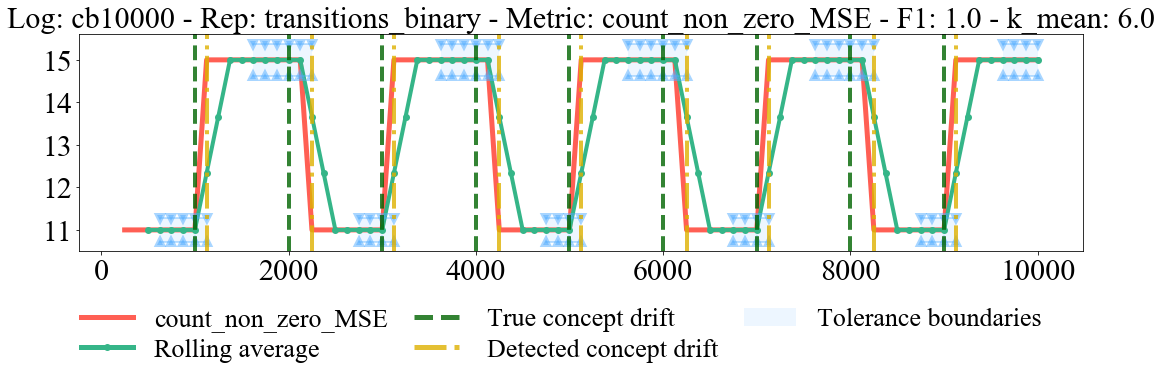

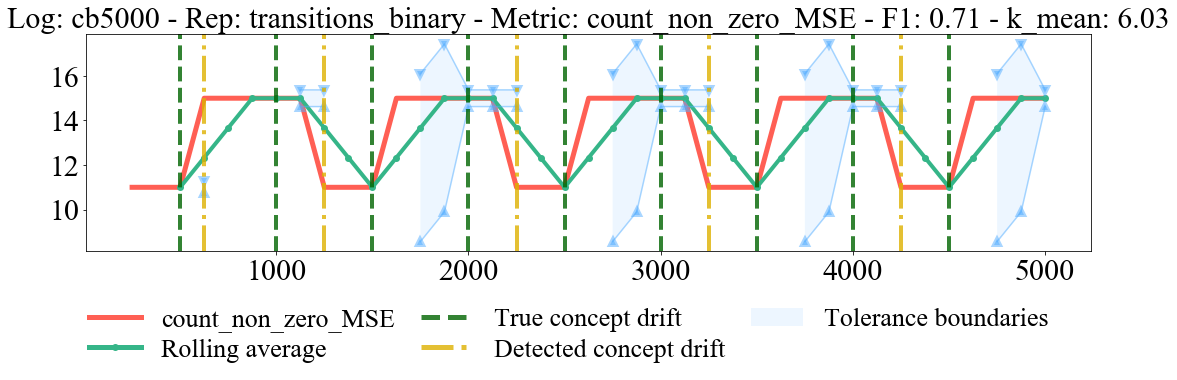

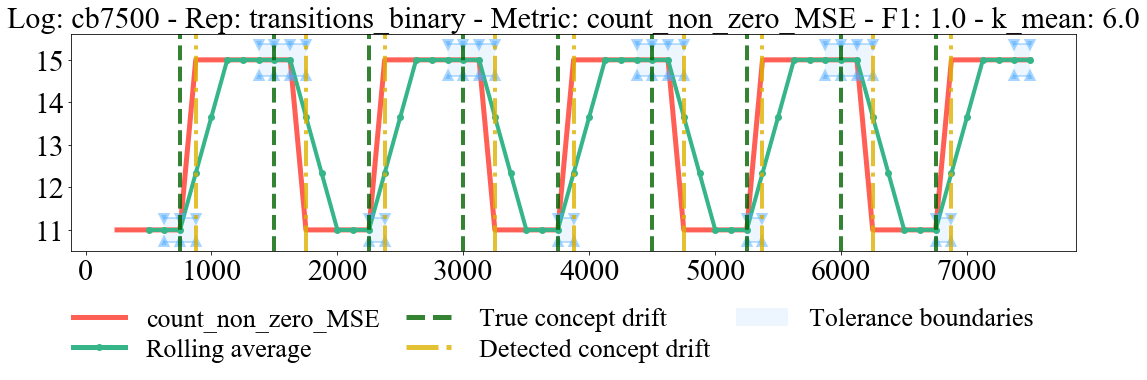

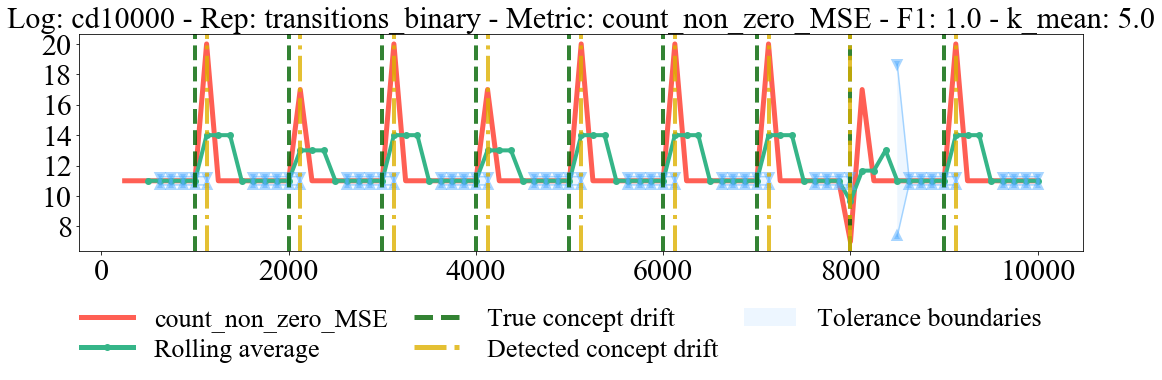

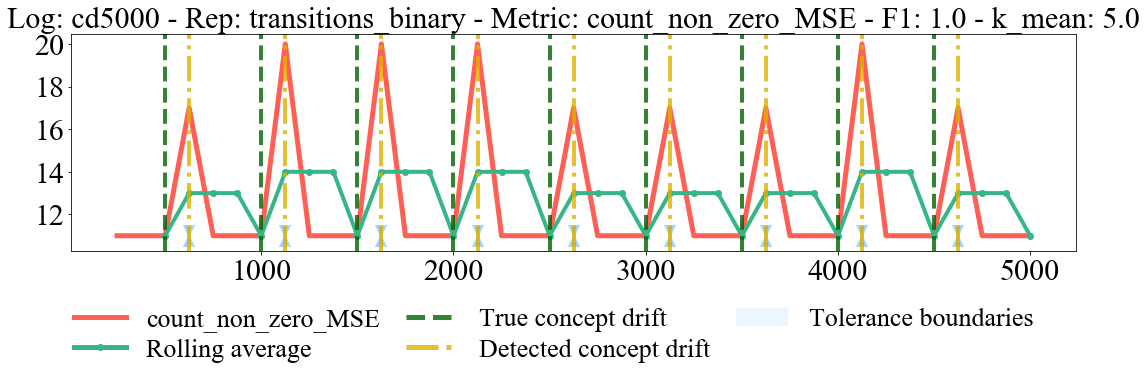

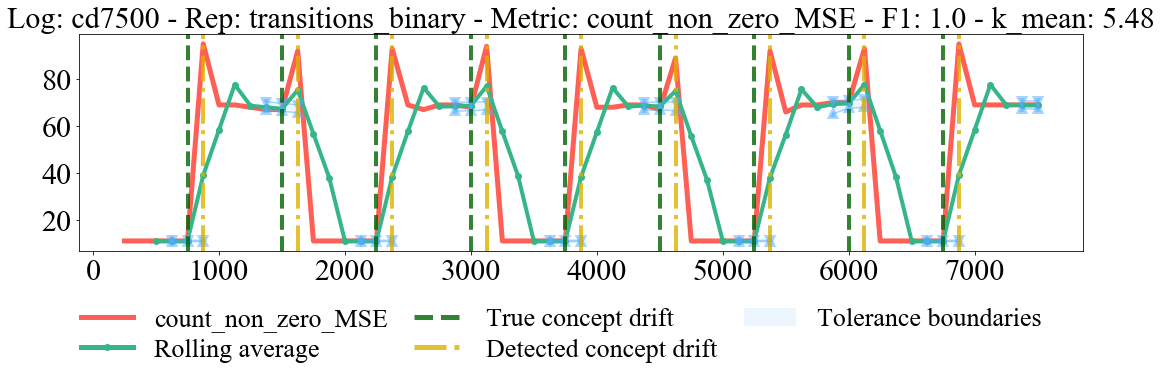

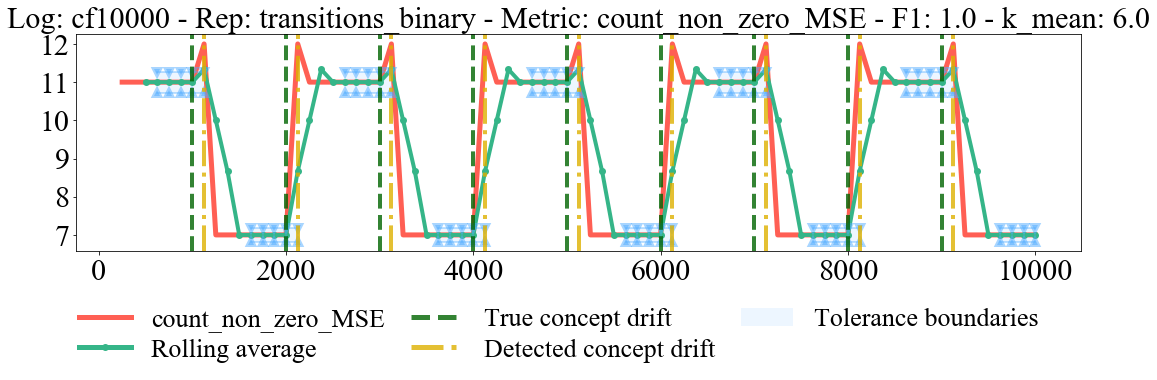

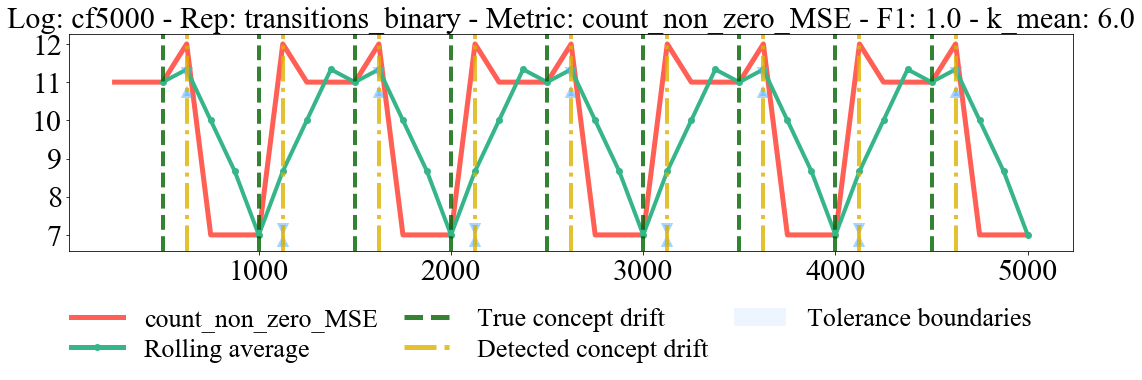

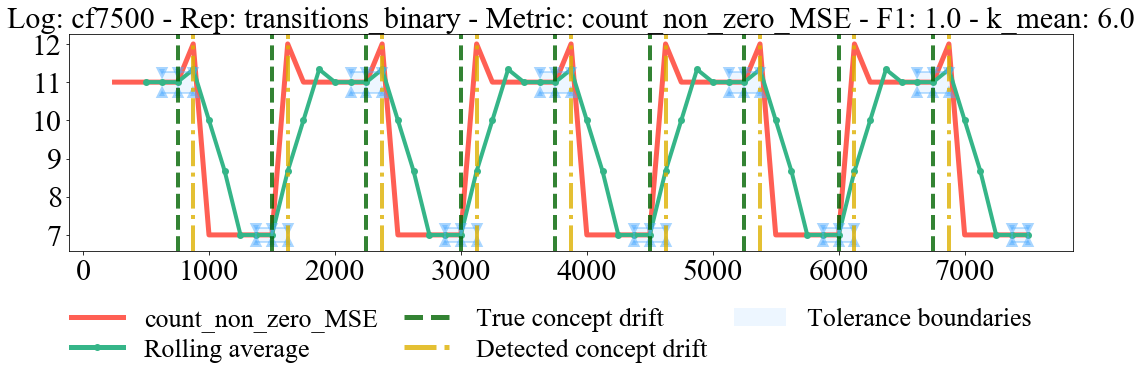

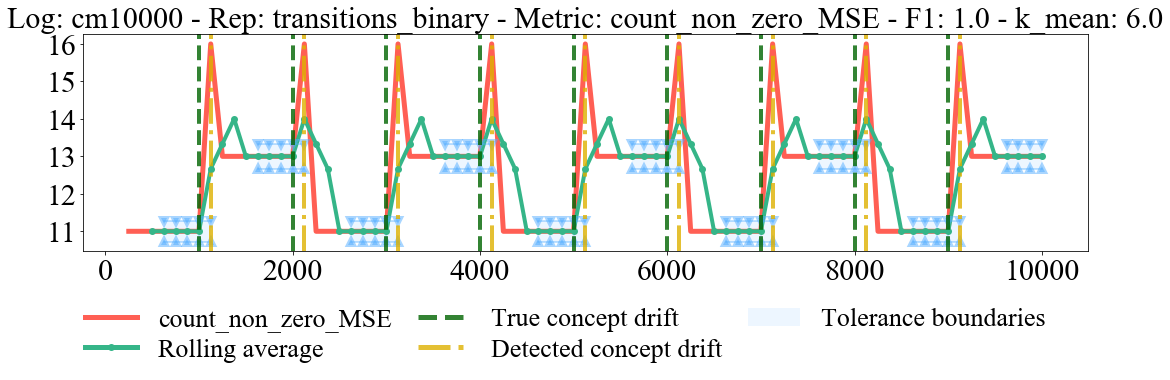

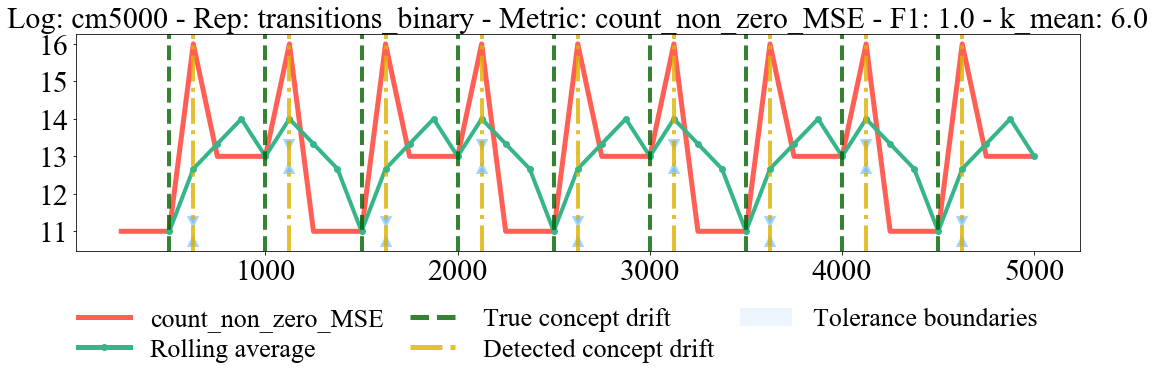

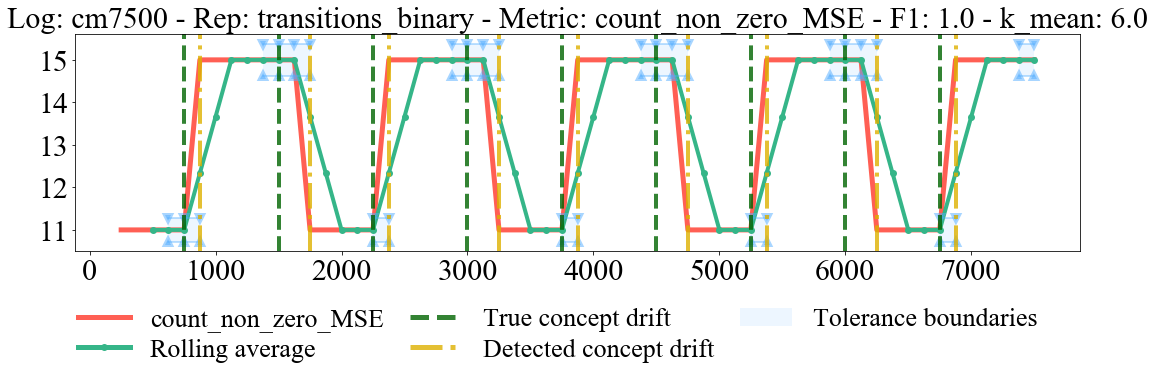

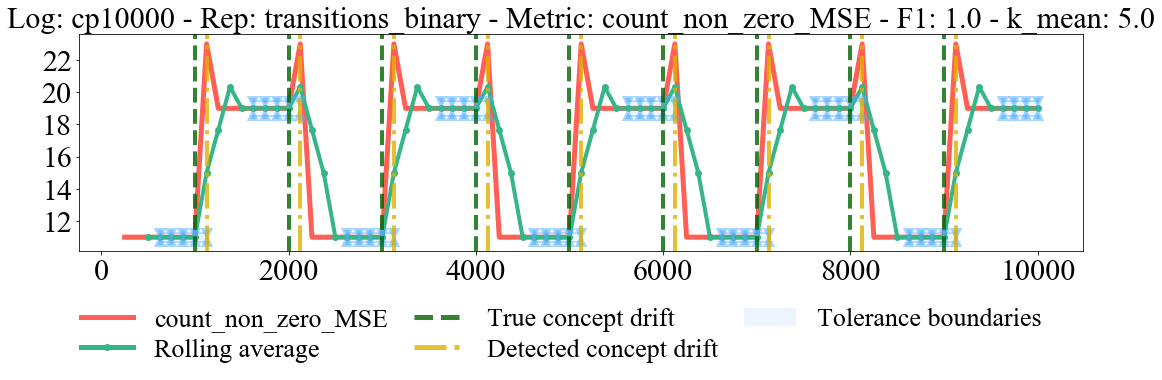

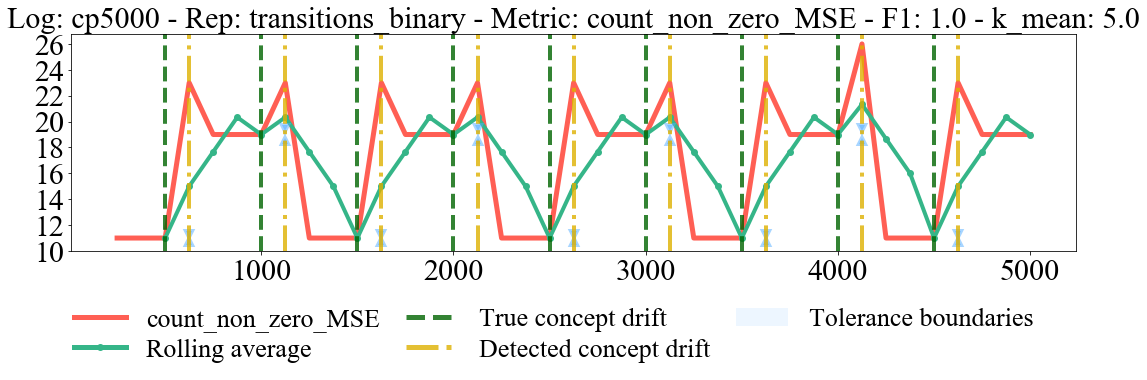

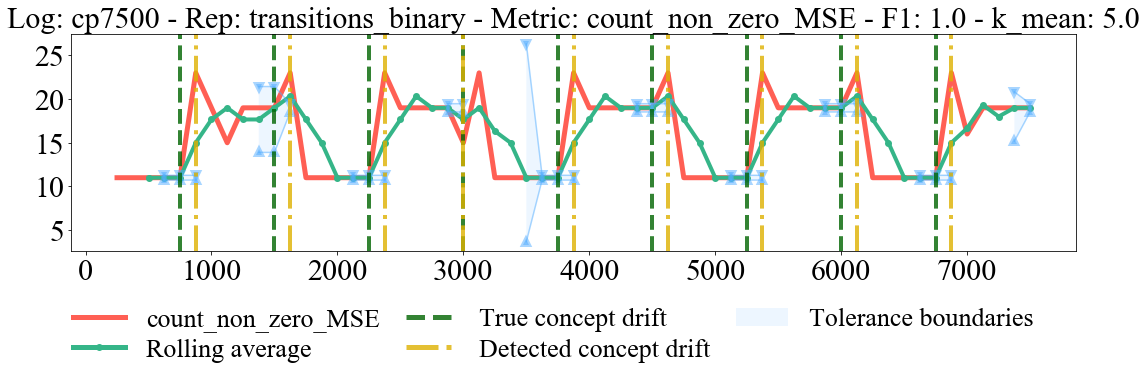

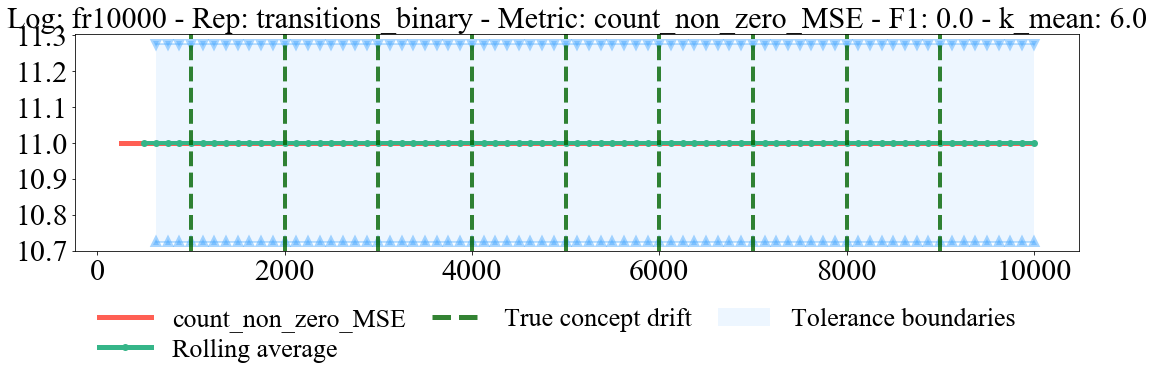

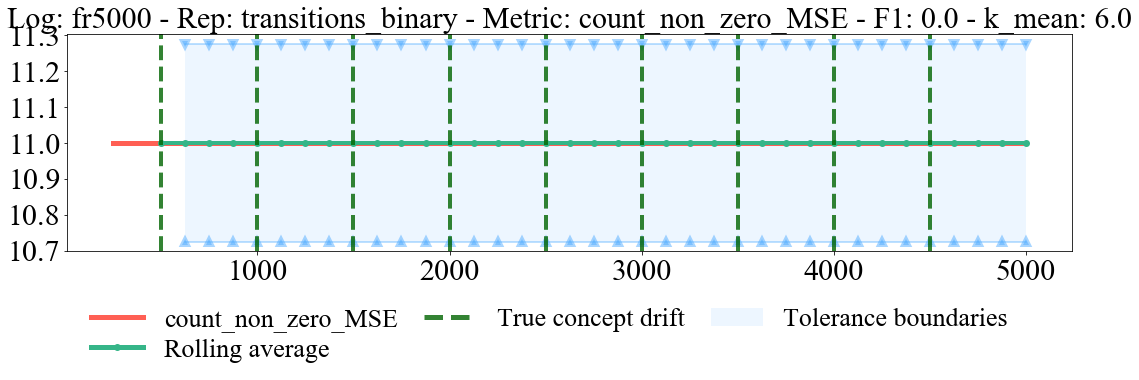

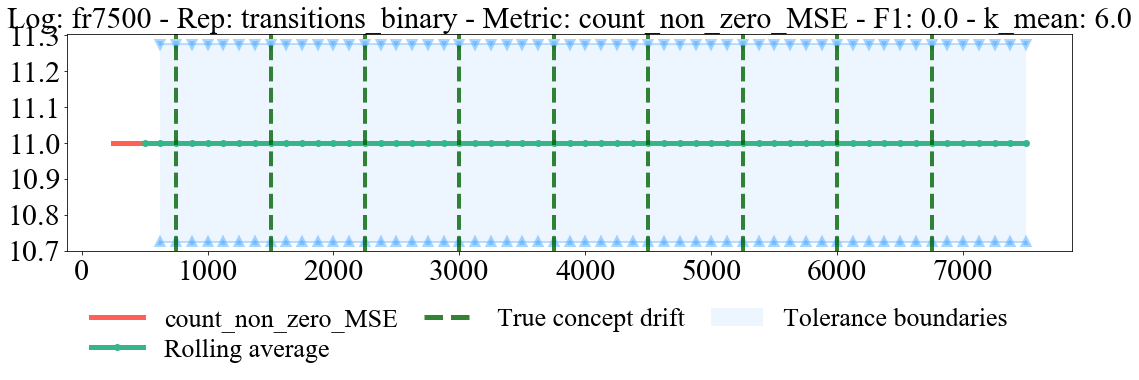

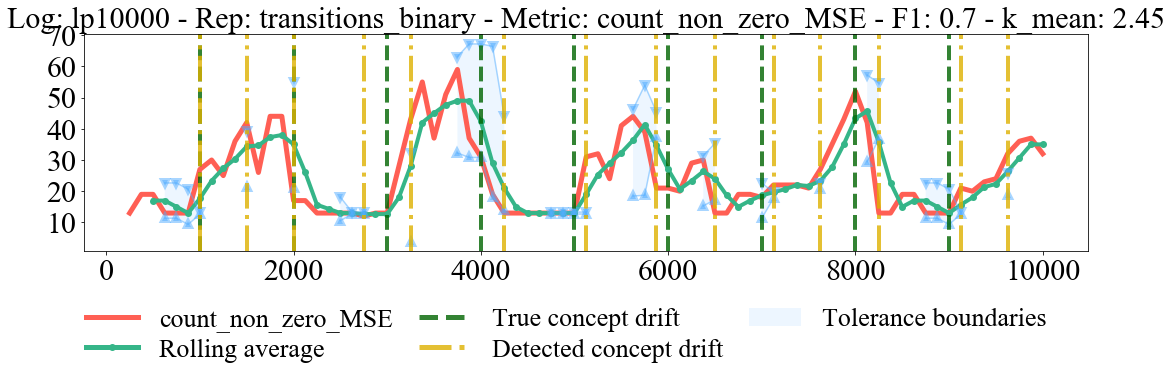

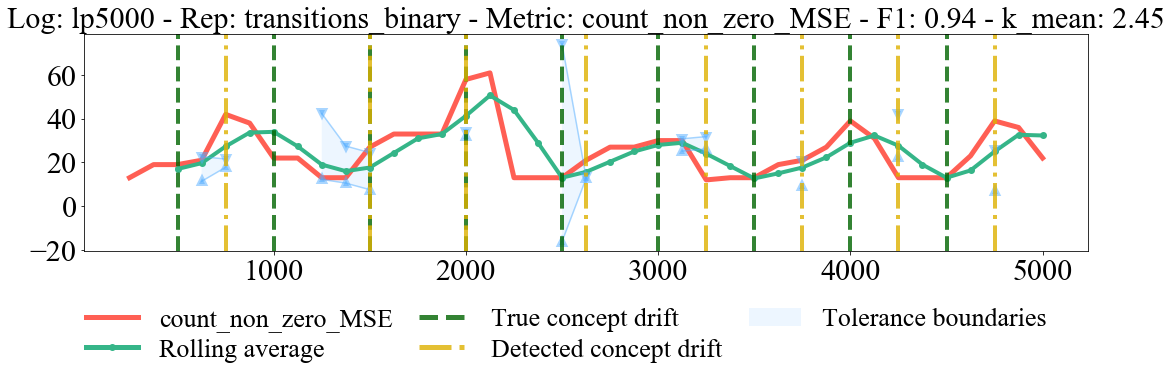

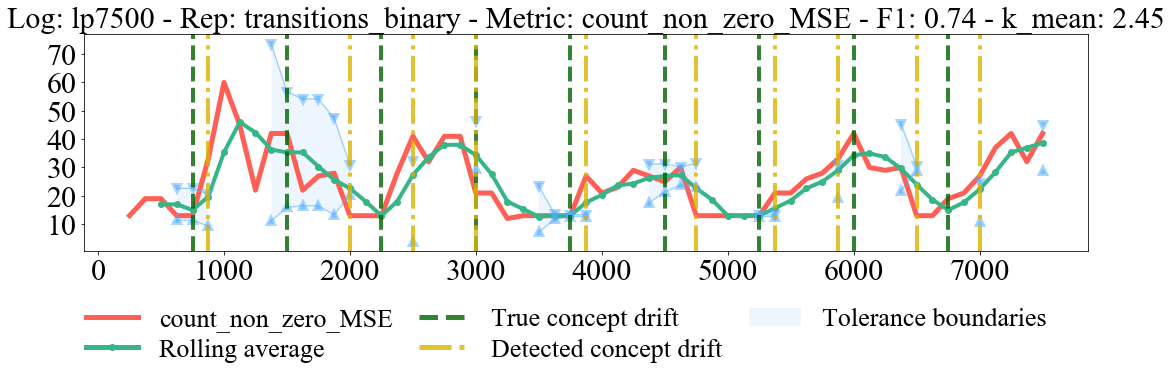

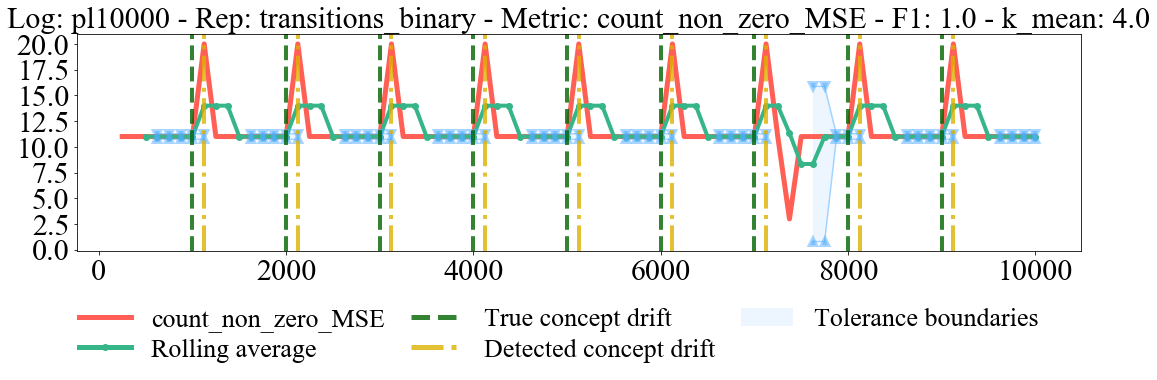

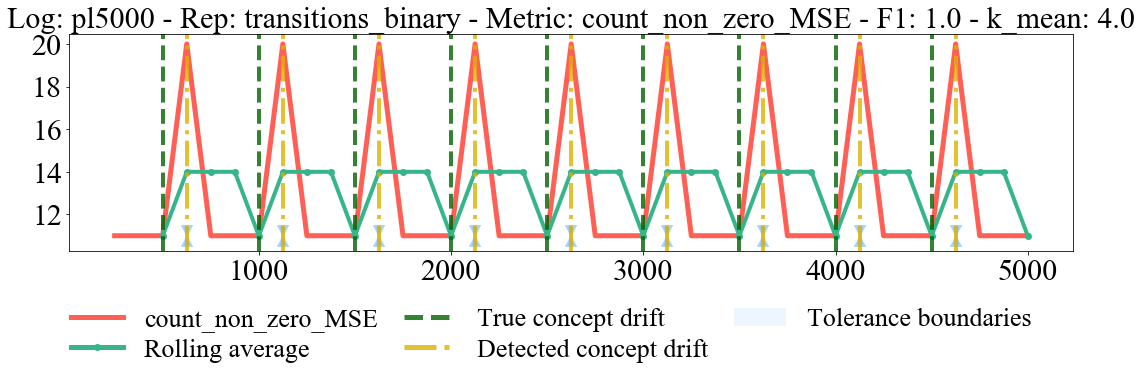

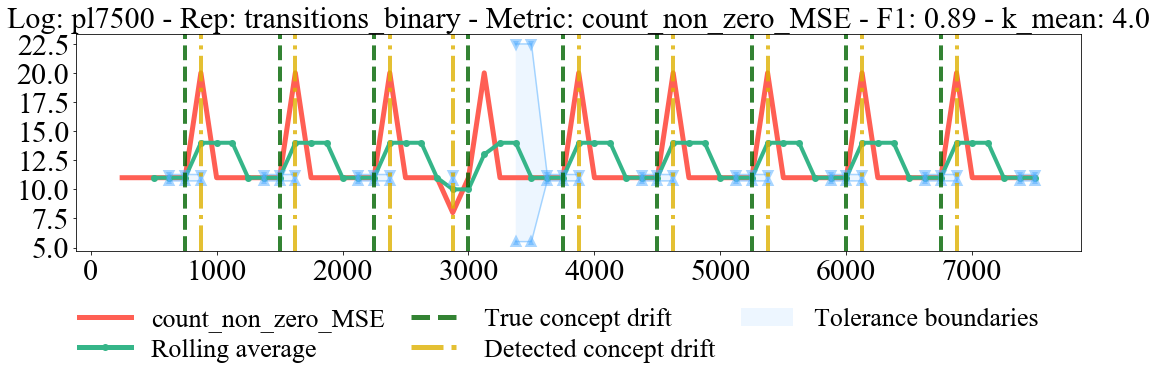

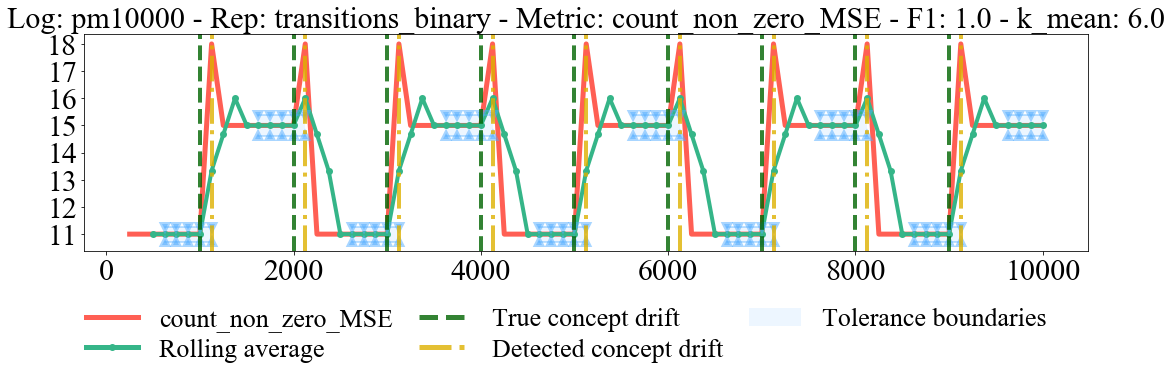

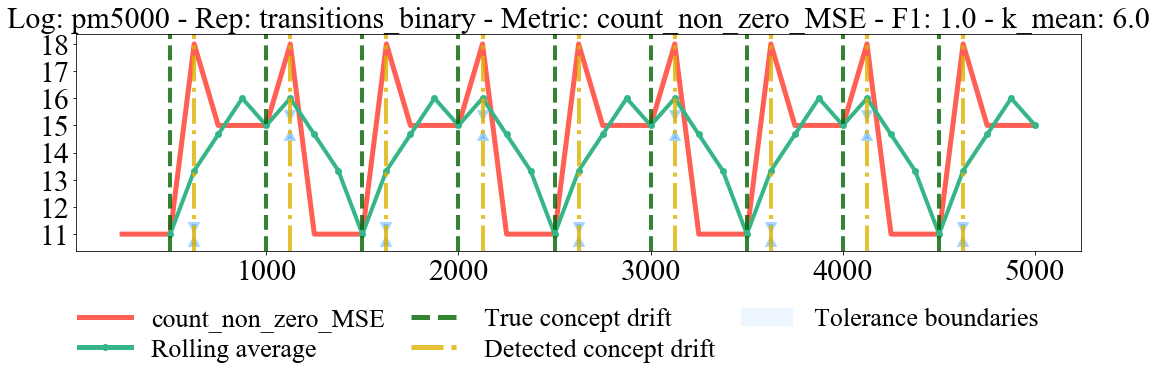

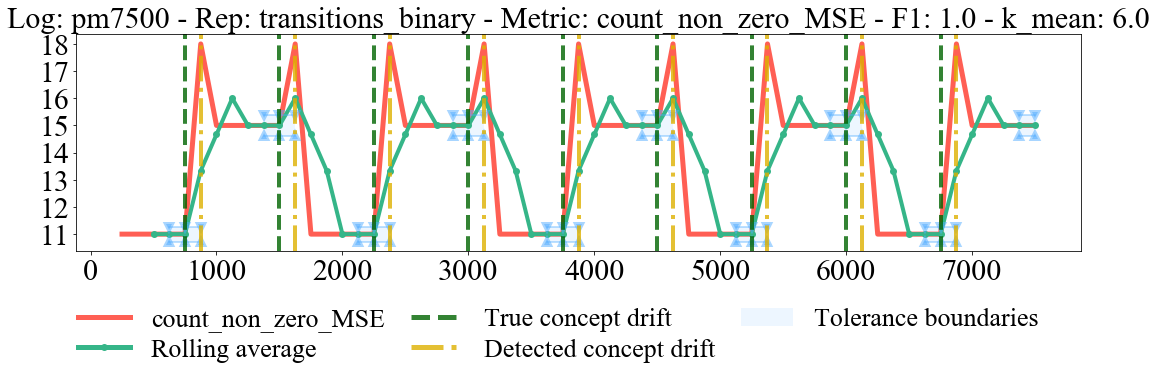

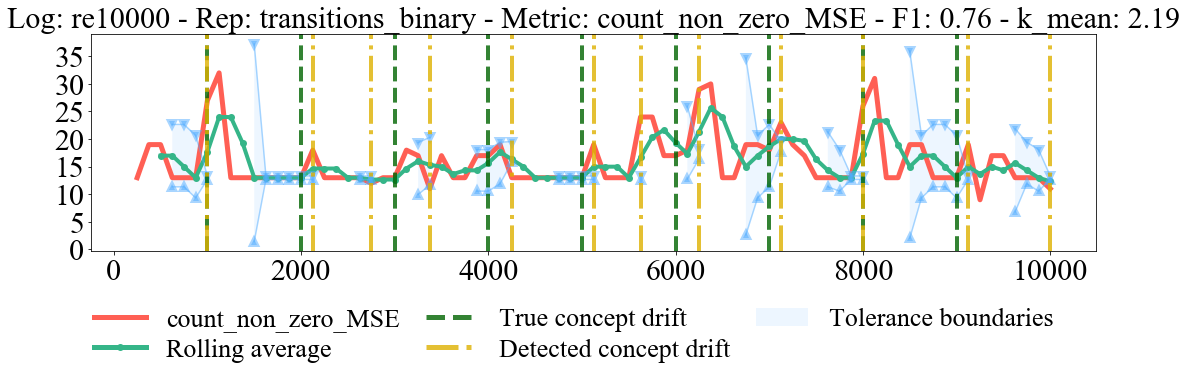

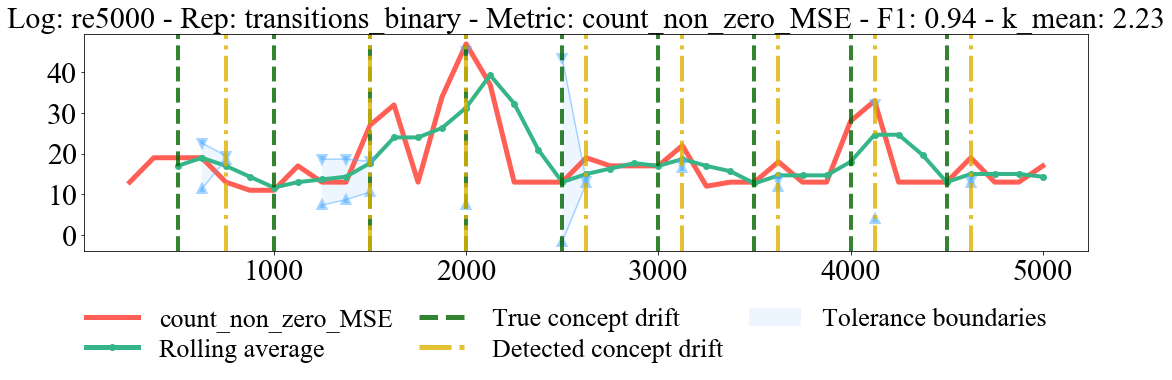

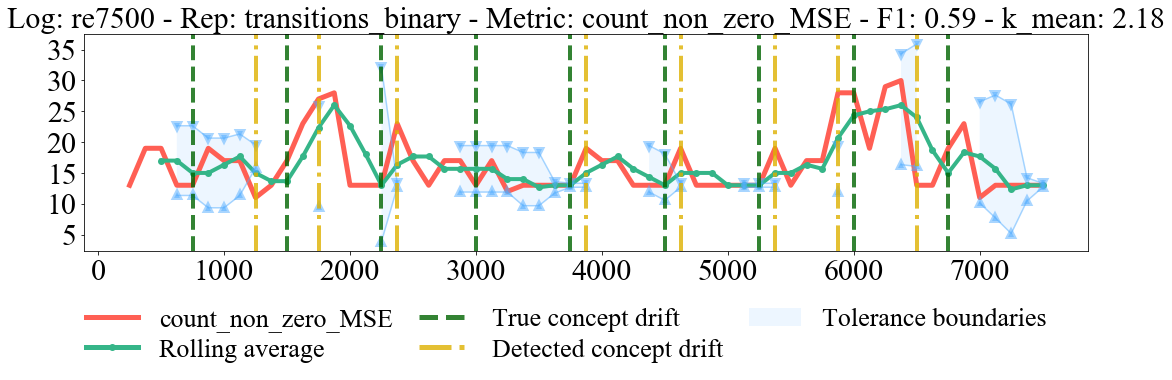

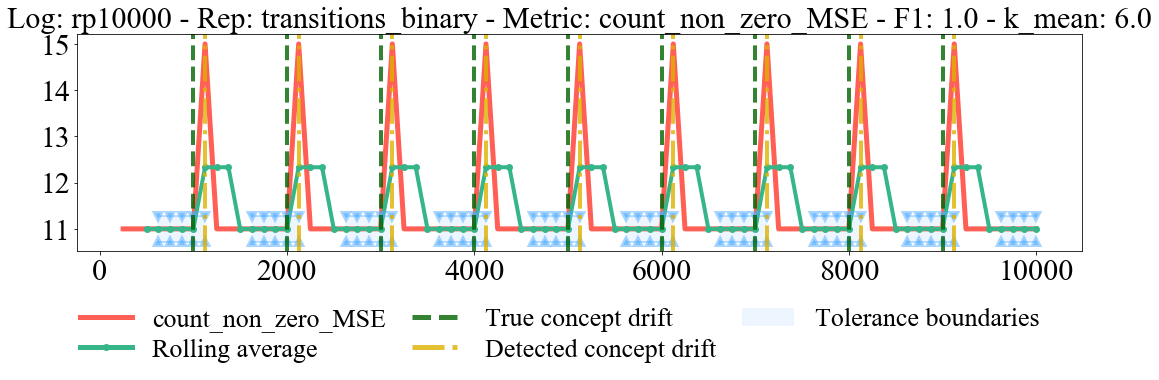

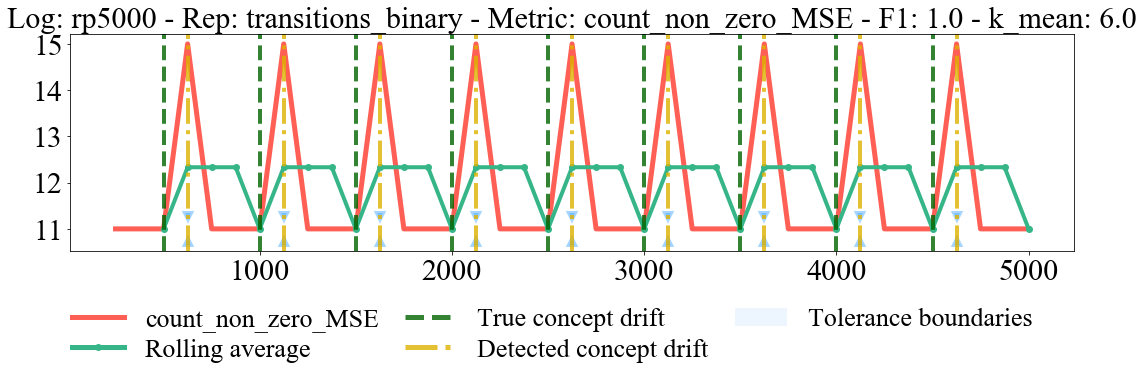

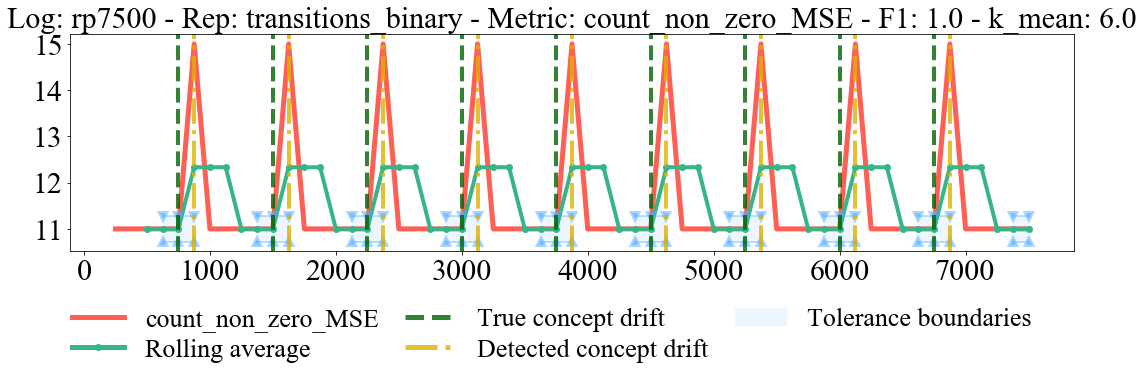

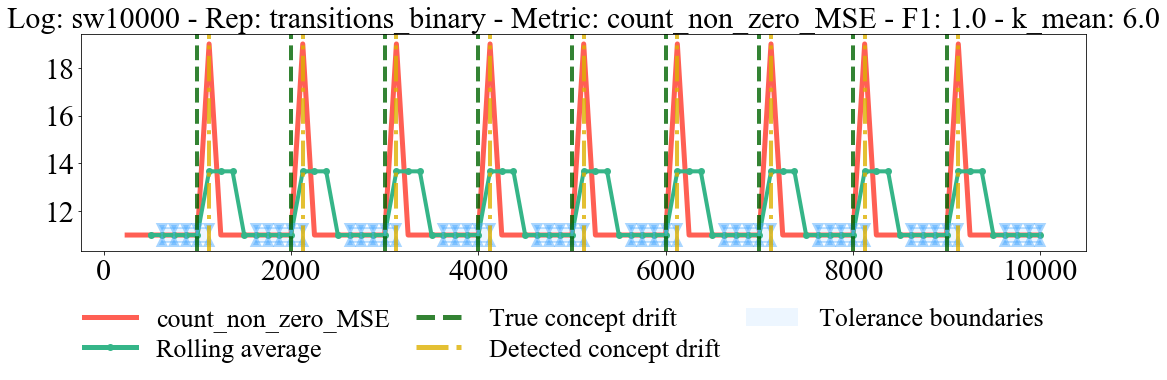

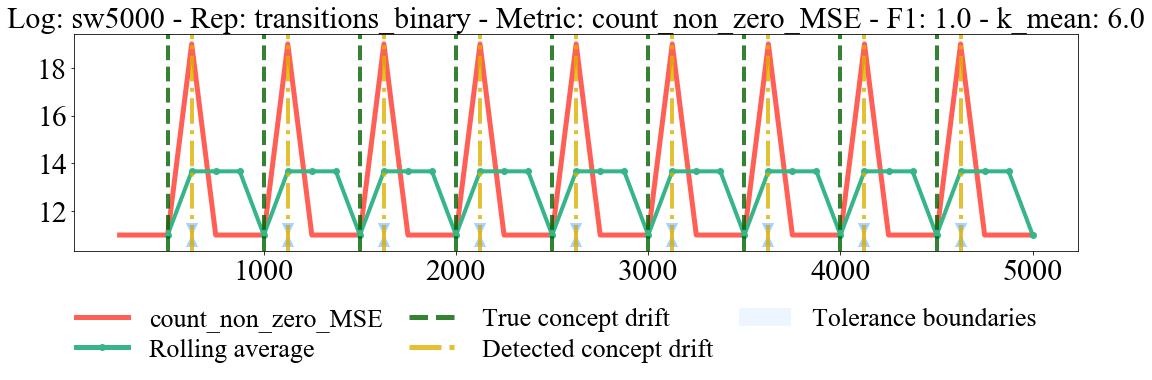

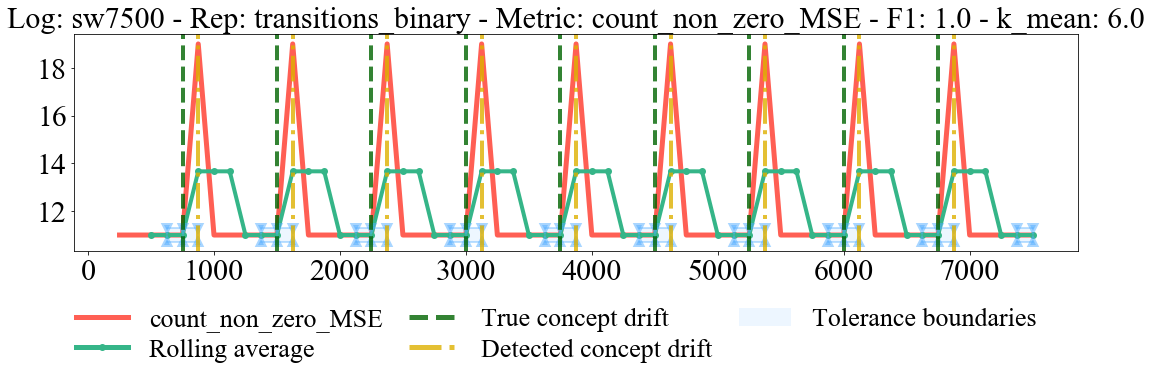

In [27]:
with PdfPages(OUTPUT_RESULTS + 'results_plot_deteccao_drift_'+model+'.pdf') as pdf:
    for row in range(0,len(show_result)):

        show_result_log = [x for x in logs if show_result.iloc[row]["tipo_mudanca"] in x 
             and str(show_result.iloc[row]["log_size"]/1000) in 
                        str(float(x.split("/")[-1][:-5].replace("k", "").replace(x.split("/")[-2],"")))]

        log_read = pm.all_prep(open(show_result_log[0]))
        tokens = lr.get_traces_as_tokens(log_read)

        run_df, X = off_sc.run_offline_clustering_window(
            tokens,
            objects["representation"][show_result.iloc[row]['representation']],
            objects["model"][show_result.iloc[row]['model']],
            distance_list,
            int(show_result.iloc[row]['window_size']),
            sliding_window=False,
            sliding_step=1
        )

        drifts, not_drifts, info = dd.detect_concept_drift(
            run_df,
            show_result.iloc[row]['measure'],
            rolling_window=show_result.iloc[row]['rolling_window'],
            std_tolerance=show_result.iloc[row]['std_tolerance'],
            min_tol=show_result.iloc[row]['min_tol']
        )

        plts.plot_deteccao_drift(
            run_df,
            show_result.iloc[row]['measure'],
            show_result.iloc[row]['Drifts_Found'],
            show_result.iloc[row]['Resp'],
            info['means'],
            info['lowers'],
            info['uppers'],
            save_png=""
        )
        plt.title("Log: " + show_result.iloc[row]["tipo_mudanca"] + str(show_result.iloc[row]["log_size"]) 
                      + " - Rep: " + show_result.iloc[row]["representation"] 
                      + " - Metric: " + show_result.iloc[row]["measure"]
                      + " - F1: " + str(round(show_result.iloc[row]["F1"],2))
                      + " - k_mean: " + str(round(np.mean(run_df["k"]),2))
                  , size=30)
        
        pdf.savefig()
        plt.show()

    